In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
from kalman import Kalman, LDS, KalmanNet, LDSNet, c_to_d_kf

In [2]:
def test_kalman_net(neurons, plot=True):
    SYS_TAU = 0.01
    SIM_TIME = 10*SYS_TAU

    dt = 0.001
    A = np.array([[-1/SYS_TAU]])
    B = np.array([[1/SYS_TAU]])
    C = np.array([[1]])
    Q = np.array([[0.1/dt]])
    R = np.array([[0.01]])

    A_DT, B_DT, Q_DT = c_to_d_kf(A, B, Q, dt=dt)
    
    model = nengo.Network()
    with model:
        stim = nengo.Node([1])
        lds_net = LDSNet(A, B, C, Q=Q, R=R)
        nengo.Connection(stim, lds_net.input, synapse=None)
        stim_probe = nengo.Probe(stim)
        lds_state_probe = nengo.Probe(lds_net.state)
        lds_out_probe = nengo.Probe(lds_net.output)
        
        kalman_net = KalmanNet(neurons, A_DT, B_DT, C, Q_DT, R, dt=dt)
        nengo.Connection(stim, kalman_net.input_system, synapse=None)
        nengo.Connection(lds_net.output, kalman_net.input_measurement, synapse=None)

        kalman_ref = KalmanNet(1, A_DT, B_DT, C, Q_DT, R, dt=dt, neuron_type=nengo.neurons.Direct())
        nengo.Connection(stim, kalman_ref.input_system, synapse=None)
        nengo.Connection(lds_net.output, kalman_ref.input_measurement, synapse=None)
                
        k_ref_probe = nengo.Probe(kalman_ref.readout)
        k_probe = nengo.Probe(kalman_net.readout)
        
    sim = nengo.Simulator(model, dt=dt/5)
    sim.run(SIM_TIME)
    
    if plot:
        fig, axs = plt.subplots(ncols=2, figsize=(15, 6))
        axs[0].plot(sim.trange(), sim.data[stim_probe], 'k', label="stim")
        axs[0].plot(sim.trange(), sim.data[lds_state_probe], label="state")
        axs[0].plot(sim.trange(), sim.data[lds_out_probe], "+", alpha=0.3, label="measurement")
        axs[0].plot(sim.trange(), sim.data[k_probe], alpha=0.5, label="kalman estimate")
        axs[0].plot(sim.trange(), sim.data[k_ref_probe], alpha=0.5, label="kalman reference")
        axs[0].legend(loc="lower right", fontsize=12)
        axs[0].set_xlabel("Time")
        axs[1].plot(sim.trange(), sim.data[stim_probe], 'k', label="stim")
        axs[1].plot(sim.trange(), sim.data[lds_state_probe], label="state")
        axs[1].plot(sim.trange(), sim.data[lds_out_probe], "+", alpha=0.3, label="measurement")
        axs[1].plot(sim.trange(), sim.data[k_probe], alpha=0.5, label="kalman estimate")
        axs[1].plot(sim.trange(), sim.data[k_ref_probe], alpha=0.5, label="kalman reference")
        axs[1].set_ylim((0.7, 1.3))
        axs[1].set_ylabel("Time")
        fig.suptitle("{} Neurons".format(neurons))

    rmse_kref = np.mean((sim.data[k_ref_probe]-sim.data[lds_state_probe])**2)**.5
    rmse_k = np.mean((sim.data[k_probe]-sim.data[lds_state_probe])**2)**.5
    return rmse_kref, rmse_k

Building finished in 0:00:01.                                                                                                                                                                                       
Simulating finished in 0:00:01.                                                                                                                                                                                     
Building finished in 0:00:01.                                                                                                                                                                                       
Simulating finished in 0:00:01.                                                                                                                                                                                     
Building finished in 0:00:01.                                                                                                                       

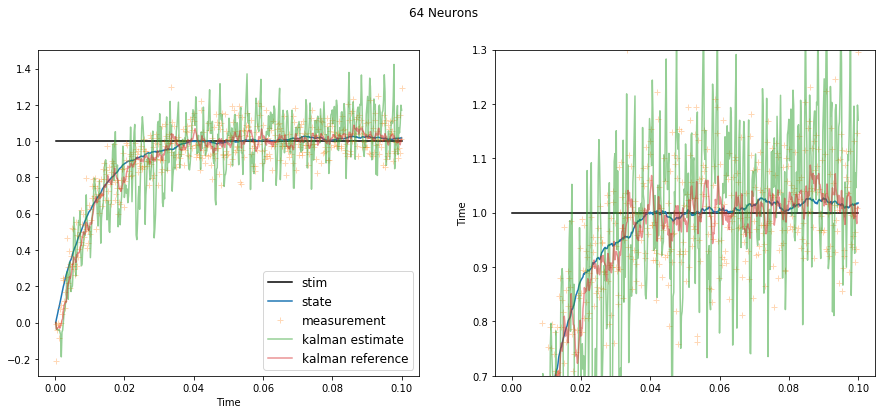

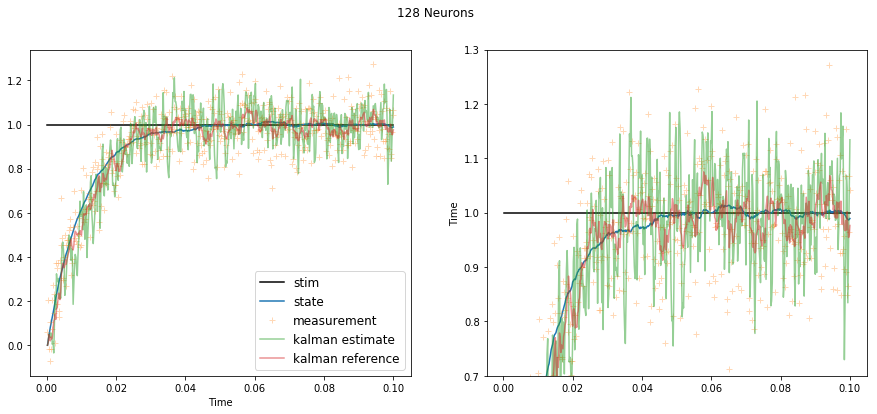

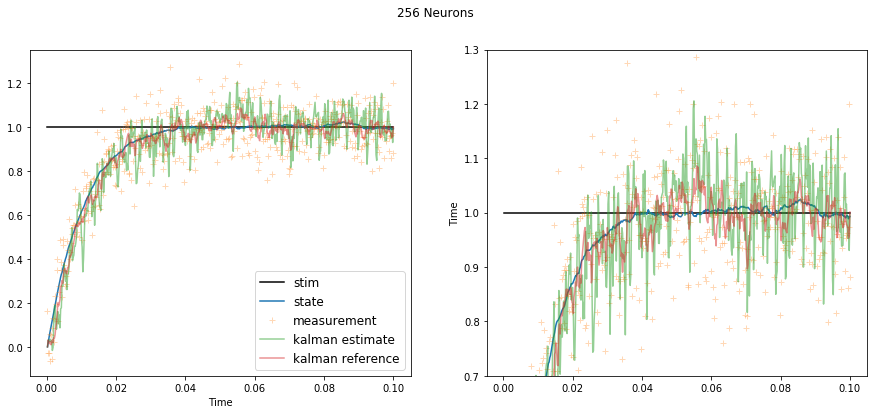

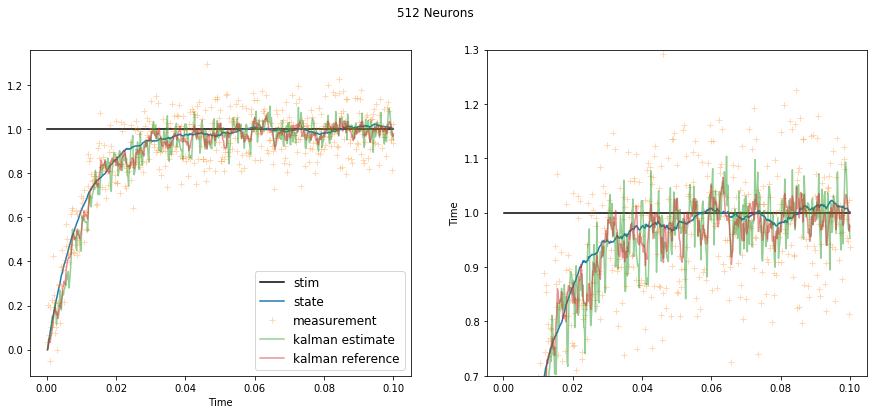

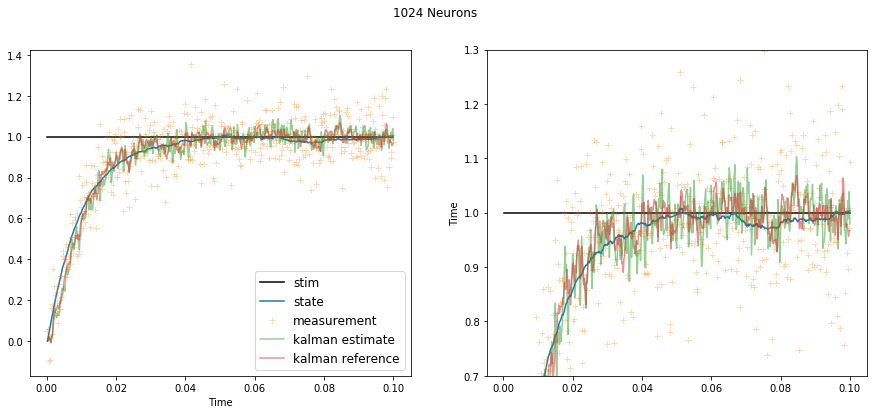

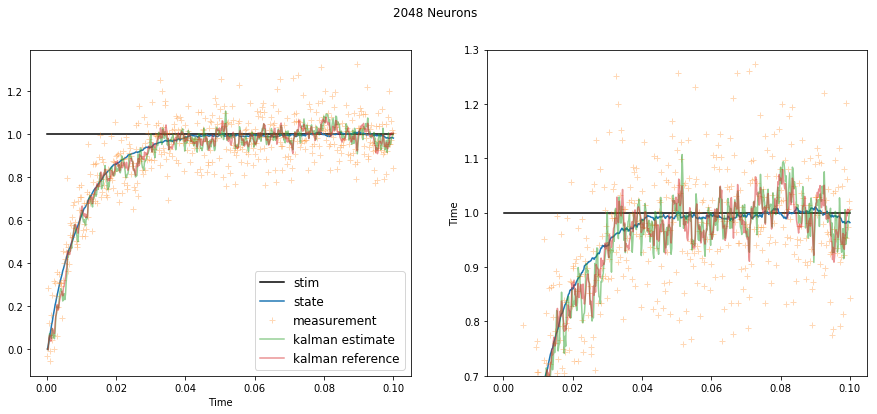

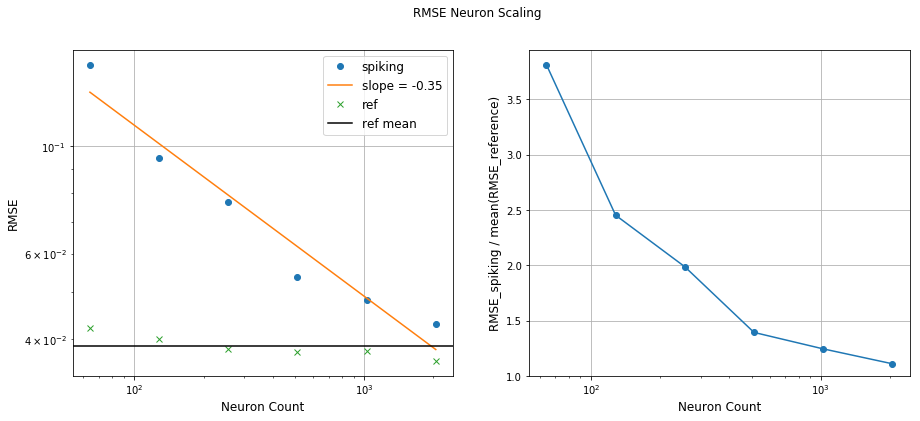

In [3]:
def sweep_k_net():
    """Track the kalman filter error with more neurons"""
    NEURONS = [64, 128, 256, 512, 1024, 2048]
    rmse_ref = np.zeros(len(NEURONS))
    rmse_spiking = np.zeros(len(NEURONS))
    rmse_ref[0] = 1
    for idx, neurons in enumerate(NEURONS):
        rmse_ref[idx], rmse_spiking[idx] = test_kalman_net(neurons=neurons, plot=True)
    
    log_nrns = np.log2(NEURONS)
    log_rmse = np.log2(rmse_spiking)
    A_fit = np.ones((len(NEURONS), 2))
    A_fit[:, 0] = log_nrns
    b_fit = log_rmse
    fit = np.linalg.lstsq(A_fit, b_fit, rcond=None)
    fit_slope, fit_intercept = fit[0]
    fit_rmse = 2**(fit_slope*log_nrns+fit_intercept)
    
    fig, axs = plt.subplots(ncols=2, figsize=(15, 6))
    axs[0].loglog(NEURONS, rmse_spiking, 'o', label="spiking")
    axs[0].loglog(NEURONS, fit_rmse, label="slope = {:.2f}".format(fit_slope))
    axs[0].loglog(NEURONS, rmse_ref, 'x', label="ref")
    axs[0].axhline(np.mean(rmse_ref), color="k", label="ref mean")
    axs[0].set_xlabel("Neuron Count", fontsize=12)
    axs[0].set_ylabel("RMSE", fontsize=12)
    axs[0].legend(loc="upper right", fontsize=12)
    axs[0].grid()
    axs[1].semilogx(NEURONS, rmse_spiking/np.mean(rmse_ref), '-o')
    axs[1].set_xlabel("Neuron Count", fontsize=12)
    axs[1].set_ylabel("RMSE_spiking / mean(RMSE_reference)", fontsize=12)
    axs[1].grid()
    axs[1].set_ylim((1, axs[1].get_ylim()[1]))
    fig.suptitle("RMSE Neuron Scaling", fontsize=12)
    plt.show()
sweep_k_net()

In [ ]:
def test_kalmannet_2d():
    """Test LDSNet correctness
    
    """
    SIM_TIME = 2.
    STIM_TIME = 0.5
    SYS_TAU = 0.1
    FREQ = 2.
    A = 2*np.pi*np.eye(2).T
    B = np.eye(2)
    C = np.eye(2)
    
    model = nengo.Network()
    with model:
        stim = nengo.Node(lambda t: test_stim(t, STIM_TIME))
        lds_net = LDSNet(A, B, C)
        nengo.Connection(stim, lds_net.input, synapse=None)
        
        stim_probe = nengo.Probe(stim)
        lds_probe = nengo.Probe(lds_net.state)
    
    sim = nengo.Simulator(model, dt=0.001)
    sim.run(SIM_TIME)
    
    fig, axs = plt.subplots(nrows=2, figsize=(8, 8))
    axs[0].plot(sim.data[lds_probe][:, 0], sim.data[lds_probe][:, 1])
    axs[1].plot(sim.trange(), sim.data[stim_probe], label="stim")
    axs[1].plot(sim.trange(), sim.data[lds_probe], label="state")

In [2]:
def run_lds_kf(lds, kf, steps, u=0):
    """Run an experiment with a linear dynamical system and a Kalman filter"""
    lds_x = np.zeros((steps, lds.state_dimensions))
    lds_y = np.zeros((steps, lds.output_dimensions))
    kf_xhat = np.zeros((steps, lds.state_dimensions))
    kf_p = np.zeros((steps, lds.state_dimensions, lds.state_dimensions))
    kf_k = np.zeros((steps, lds.state_dimensions, lds.output_dimensions))
    
    lds_x[0, :], lds_y[0, :] = lds.initial_condition
    kf_xhat[0, :] = kf.xhat
    kf_p[0, :] = kf.p
    for step in range(steps)[1:]:
        lds_x[step, :], lds_y[step, :] = lds.step(u)
        kf_xhat[step, :], kf_p[step, :], kf_k[step, :] = kf.step(u, lds_y[step, :])
    kf_k[0, :] = kf_k[1, :]
    lds_data = (lds_x, lds_y)
    kf_data = (kf_xhat, kf_p, kf_k)
    return lds_data, kf_data

def plot_lds_kf_1d(lds_data, kf_data):
    fig, axs = plt.subplots(nrows=3, figsize=(8, 6))
    x, y = lds_data
    xhat, p, k = kf_data
    axs[0].plot(x, 'k', label="truth")
    axs[0].plot(y, '+', label="measurements")
    axs[0].plot(xhat, 'k--', label="estimate")
    axs[0].legend(bbox_to_anchor=(1,0.5), loc="center left")
    axs[1].plot(p, label="P")
    axs[1].legend(loc="upper right")
    axs[2].plot(k, label="K")
    axs[2].legend(loc="upper right")
    return axs
    

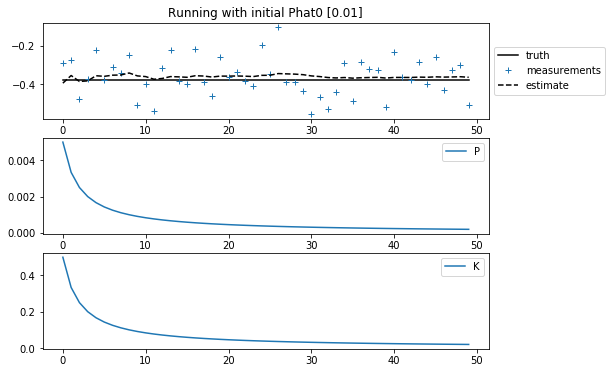

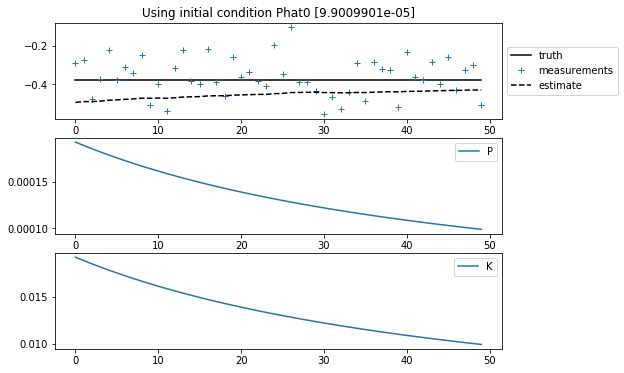

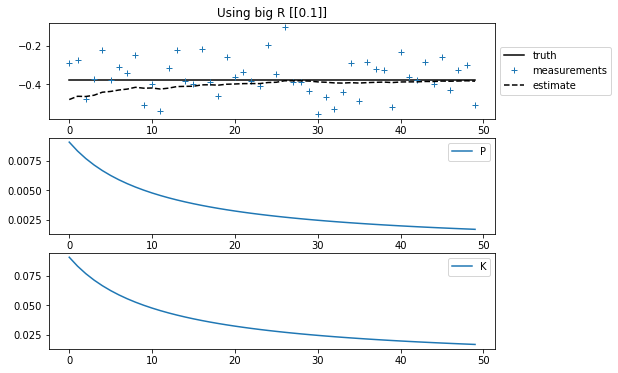

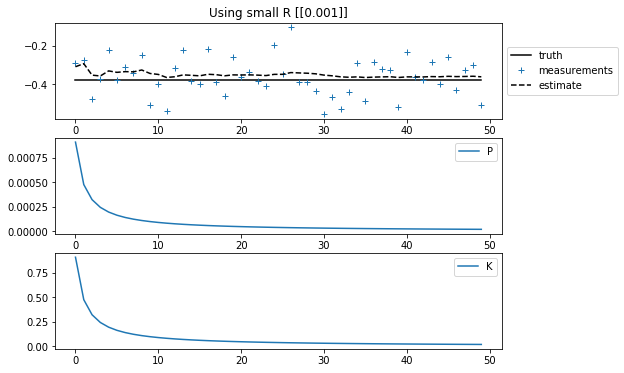

In [3]:
# 1d constant dynamics, no noise
def replicate_introduction():
    """Test that the Kalman filter works on a 1D constant system with no noise"""
    A = np.array([[1]]) # no dynamics, system constant
    B = np.array([[0]]) # no input
    C = np.array([[1]]) # measure state directly
    D = np.array([[0]]) # no pass through
    Q = np.array([[0]]) # no process noise
    R = np.array([[0.01]])
    x0 = np.array([-0.37727])
    xhat0 = np.array([-0.5])
    Phat0 = np.array([0.01])

    N_STEPS = 50
    x = np.zeros(N_STEPS)
    z = np.zeros(N_STEPS)

    # run the underlying LDS
    lds = LDS(A, B, C, D, Q, R, x0)
    for step in range(N_STEPS):
        x[step], z[step] = lds.step(0)
    lds_data = (x, z)
    
    # run the KF
    kf = Kalman(A, B, C, Q, R, xhat0, Phat0)
    kf_xhat = np.zeros((N_STEPS, 1))
    kf_p = np.zeros((N_STEPS, 1))
    kf_k = np.zeros((N_STEPS, 1))
    for step in range(N_STEPS):
        kf_xhat[step, :], kf_p[step, :], kf_k[step, :] = kf.step(0, z[step])
    kf_data = (kf_xhat, kf_p, kf_k)
    axs = plot_lds_kf_1d(lds_data, kf_data)
    axs[0].set_title("Running with initial Phat0 {}".format(Phat0))
    
    # what if the KF starts from closer to SS initial condition?
    Phat0 = kf_p[-1,:]
    kf = Kalman(A, B, C, Q, R, xhat0, Phat0)
    for step in range(N_STEPS):
        kf_xhat[step, :], kf_p[step, :], kf_k[step, :] = kf.step(0, z[step])
    axs = plot_lds_kf_1d(lds_data, kf_data)
    axs[0].set_title("Using initial condition Phat0 {}".format(Phat0))
    
    # what if our measurement noise variance assumption is too big?
    R = np.array([[0.1]])
    Phat0 = np.array([0.01])
    kf = Kalman(A, B, C, Q, R, xhat0, Phat0)
    for step in range(N_STEPS):
        kf_xhat[step, :], kf_p[step, :], kf_k[step, :] = kf.step(0, z[step])
    axs = plot_lds_kf_1d(lds_data, kf_data)
    axs[0].set_title("Using big R {}".format(R))
    
    # what if our measurement noise variance assumption is too small?
    R = np.array([[0.001]])
    kf = Kalman(A, B, C, Q, R, xhat0, Phat0)
    for step in range(N_STEPS):
        kf_xhat[step, :], kf_p[step, :], kf_k[step, :] = kf.step(0, z[step])
    axs = plot_lds_kf_1d(lds_data, kf_data)
    axs[0].set_title("Using small R {}".format(R))
    
replicate_introduction()
plt.show()

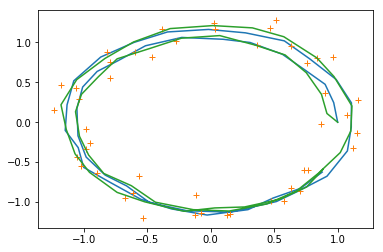

In [11]:
# 2d dyanmics, process + measure noise
def rotation_tracker():
    theta = np.pi/12
    N_STEP = 2*int(2*np.pi/theta)-1

    A = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    B = np.zeros((2, 2))
    C = np.eye(2)
    D = np.zeros((2, 2))
    x0 = np.array([1, 0])
    xhat0 = np.array([1, 0])
    Phat0 = 0.01*np.eye(2)

    Q = 0.001 * np.eye(2)
    R = 0.01 * np.eye(2)

    u = np.zeros(2)

    lds = LDS(A, B, C, D, Q, R, x0)
    kf = Kalman(A, B, C, Q, R, xhat0, Phat0)
    lds_data, kf_data = run_lds_kf(lds, kf, N_STEP, u=u)
    x, z = lds_data
    xhat, p, k = kf_data
    plt.plot(x[:, 0], x[:, 1])
    plt.plot(z[:, 0], z[:, 1], "+")
    plt.plot(xhat[:, 0], xhat[:, 1])
    plt.show()
rotation_tracker()    